## Pre 3B - Generative Adversarial Network (Assignment Preparation)

Thus far, we have discussed several **generative** models. A generative
model learns the *structure* of a set of input data. In doing so, the model
learns to *generate* new data that it has never seen before in the training
data. Last time we introduced the autoencoder showed how it can be used to generate images.

A Generative Adversarial Network (GAN) is another example of a generative
model. To motivate the GAN, let's first discuss the drawbacks of an autoencoder.

## Autoencoder Review

Here is the code that we wrote back in the autoencoder lecture.
The autoencoder model consists of an **encoder** that maps
images to a vector embedding, and a **decoder** that reconstructs
images from an embedding.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

We trained an autoencoder model on the reconstruction loss: the difference in
pixel intensities between a real image and its reconstruction.

In [ ]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, label = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
        torch.save(model.state_dict(), "autoencoder%d.pt" % epoch)
    return outputs

model = Autoencoder()
outputs = train(model, num_epochs=5)

Epoch:1, Loss:0.0098
Epoch:2, Loss:0.0059
Epoch:3, Loss:0.0044
Epoch:4, Loss:0.0035
Epoch:5, Loss:0.0030


In [ ]:
# Choose a model to load -- after 2 epochs of training
ckpt = torch.load("autoencoder1.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

Let's take a look at one MNIST image from training,
and its autoencoder reconstruction:

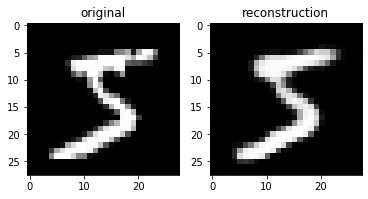

In [ ]:
original = mnist_data[0][0].unsqueeze(0)
emb = model.encoder(original)
recon_img = model.decoder(emb).detach().numpy()[0,0,:,:]

# plot the original image
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(original[0][0], cmap='gray')

# plot the reconstructed
plt.subplot(1,2,2)
plt.title("reconstruction")
plt.imshow(recon_img, cmap='gray')

The reconstruction is reasonable, but notice that the reconstruction
is blurrier than
the original image. If we perturb the embedding to generate a new image, we
still should see this blurriness:

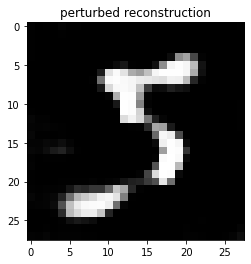

In [ ]:
# Run this a few times
x = emb + 10 * torch.randn(1, 64, 1, 1) # add a random perturbation

# reconstruct image and plot
img = model.decoder(x)[0,0,:,:]
img = img.detach().numpy()
plt.title("perturbed reconstruction")
plt.imshow(img, cmap='gray')

The reason autoencoders tend to generate blurry images is because of the
loss function that it uses.
The use of `MSELoss` (mean square error loss) has an *averaging* effect.
If the model learns that two possible values for a pixel is 0 and 1, then it
will learn to predict a value of 0.5 for that pixel to minimize the mean square error.
However, none of our training data might have a pixel intensity of 0.5 at that pixel!
A human would easily tell the difference between a generated image and a real image.

But what would be a more appropriate loss function than the MSELoss? People have
tried to come up with better loss functions, but it is difficult to construct
a general enough loss function that is appropriate for all kinds of generation
tasks. What we really want to do is **learn** a loss function!

The main idea is that generates images that fail to fool a human should also
fail to fool a neural network trained to differentiate real vs fake images.
We can use the prediction of this **discriminator** neural network to guide
the training of our **generator** network.

## Generative Adversarial Network

A generative adversarial network (GAN) model consists of two models:

- A **Generator** network $G$ that takes in a latent embedding (usually random noise)
  and generates an image like those that exists in the training data
- A **Discriminator** network $D$ that tries to distinguish between real images
  from the training data, and fake images produced by the generator

In essense, we have two neural networks that are adversaries: the generator
wants to fool the discriminator, and the discriminator wants to avoid being
fooled. The setup is known as a **min-max game**.

Let's set up a sample generator and a discriminator to start:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 28*28) # flatten image
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)
        return out

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 28*28)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = F.tanh(self.fc4(x))
        return out

D = Discriminator()
G = Generator()

For now, both the Discriminator and Generator are fully-connected networks.
One difference between these models and the previous models we've built is
that we are using a `nn.LeakyReLU` activation.

Leaky ReLU is a variation
of the ReLU activation that lets some information through, even when
its input is less than 0. The layer `nn.LeakyReLU(0.2)`
performs the computation: `x if x > 0 else 0.2 * x`.

But what loss function should we optimize? Consider the following quantity:

`P(D correctly identifies real image) + P(D correctly identifies image generated by G)`

A good **discriminator** would want to *maximize* the above quanity by altering
its parameters.

Likewise, a good **generator** would want to *minimize* the above quanity. Actually,
the only term that the generator controls is `P(D correctly identifies image generated by G)`
So, the best thing for the generator to do is alter its parameters to generate images
that can fool D.

Since we are looking at class probabilities, we will use binary cross entropy loss.

Here is a training loop to train a GAN.
For every minibatch of data, we train the discriminator for one iteration,
and then we train the generator for one iteration.

For the discriminator, we use the label `1` to represent a **fake** image, and `0` to represent
a real image.

Let's try training the network.

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data

def train(G, D, lr=0.002, batch_size=64, num_epochs=20):

    rand_size = 100;

    # optimizers for generator and discriminator
    d_optimizer = optim.Adam(D.parameters(), lr)
    g_optimizer = optim.Adam(G.parameters(), lr)

    # define loss function
    criterion = nn.BCEWithLogitsLoss()

    # get the training datasets
    train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

    # prepare data loader
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # fixed data for testing
    sample_size=16
    test_noise = np.random.uniform(-1, 1, size=(sample_size, rand_size))
    test_noise = torch.from_numpy(test_noise).float()

    for epoch in range(num_epochs):
        D.train()
        G.train()

        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)

            # rescale images to range -1 to 1
            real_images = real_images*2 - 1

            # === Train the Discriminator ===

            d_optimizer.zero_grad()

            # discriminator losses on real images
            D_real = D(real_images)
            labels = torch.zeros(batch_size)
            d_real_loss = criterion(D_real.squeeze(), labels)

            # discriminator losses on fake images
            z = np.random.uniform(-1, 1, size=(batch_size, rand_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

            D_fake = D(fake_images)
            labels = torch.ones(batch_size) # fake labels = 1
            d_fake_loss = criterion(D_fake.squeeze(), labels)

            # add up losses and update parameters
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # === Train the Generator ===
            g_optimizer.zero_grad()

            # generator losses on fake images
            z = np.random.uniform(-1, 1, size=(batch_size, rand_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

            D_fake = D(fake_images)
            labels = torch.zeros(batch_size) #flipped labels

            # compute loss and update parameters
            g_loss = criterion(D_fake.squeeze(), labels)
            g_loss.backward()
            g_optimizer.step()

        # print loss
        print('Epoch [%d/%d], d_loss: %.4f, g_loss: %.4f, '
              % (epoch + 1, num_epochs, d_loss.item(), g_loss.item()))

        # append discriminator loss and generator loss
        losses.append((d_loss.item(), g_loss.item()))

        # plot images
        G.eval()
        D.eval()
        test_images = G(test_noise)

        plt.figure(figsize=(9, 3))
        for k in range(16):
            plt.subplot(2, 8, k+1)
            plt.imshow(test_images[k,:].data.numpy().reshape(28, 28), cmap='Greys')
        plt.show()

    return losses

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1/20], d_loss: 1.4450, g_loss: 0.6199, 


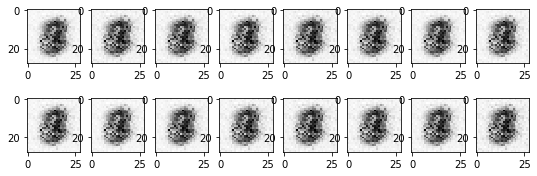

Epoch [2/20], d_loss: 0.6611, g_loss: 1.2957, 


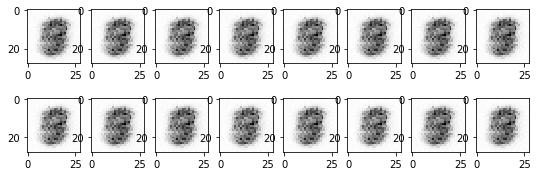

Epoch [3/20], d_loss: 1.0907, g_loss: 2.4673, 


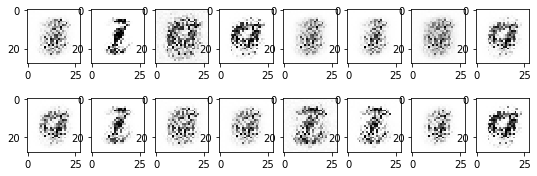

Epoch [4/20], d_loss: 0.8119, g_loss: 1.4613, 


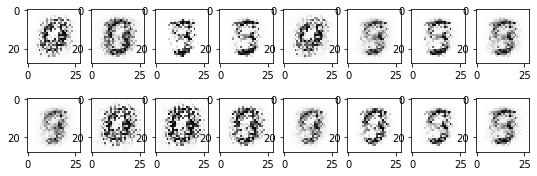

Epoch [5/20], d_loss: 0.7486, g_loss: 1.6622, 


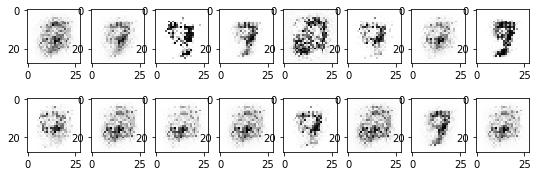

Epoch [6/20], d_loss: 0.9747, g_loss: 2.0533, 


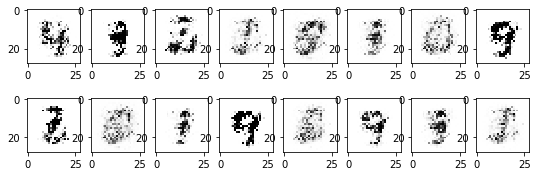

Epoch [7/20], d_loss: 0.7222, g_loss: 1.7439, 


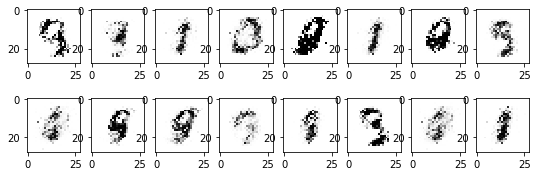

Epoch [8/20], d_loss: 0.9974, g_loss: 1.2011, 


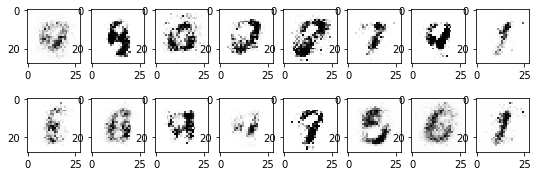

Epoch [9/20], d_loss: 1.1810, g_loss: 1.1511, 


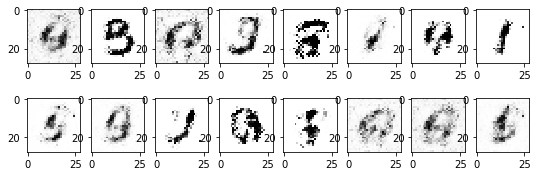

Epoch [10/20], d_loss: 1.4023, g_loss: 1.3288, 


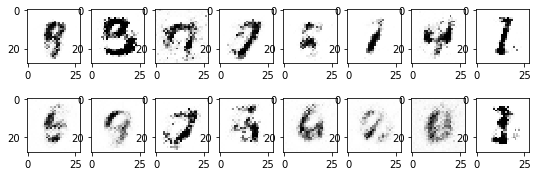

Epoch [11/20], d_loss: 1.1926, g_loss: 1.4013, 


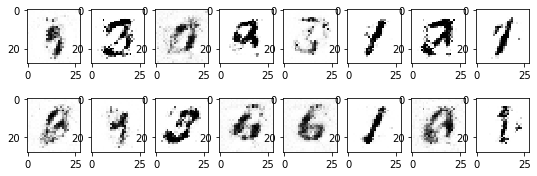

Epoch [12/20], d_loss: 1.2815, g_loss: 0.9694, 


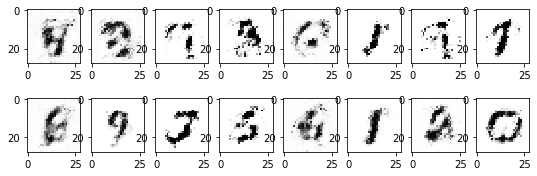

Epoch [13/20], d_loss: 1.3035, g_loss: 0.8163, 


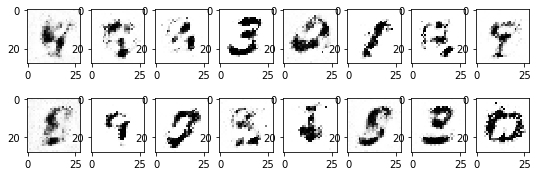

Epoch [14/20], d_loss: 1.3194, g_loss: 0.8675, 


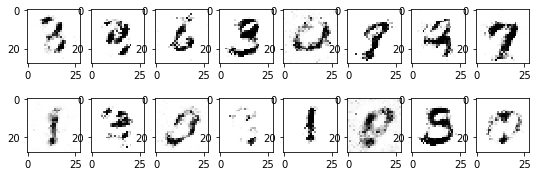

Epoch [15/20], d_loss: 1.3067, g_loss: 1.5526, 


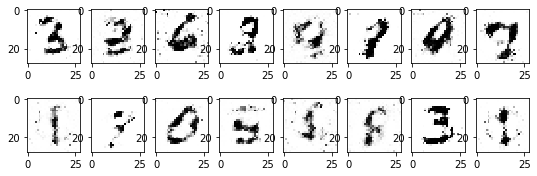

Epoch [16/20], d_loss: 1.1316, g_loss: 0.9302, 


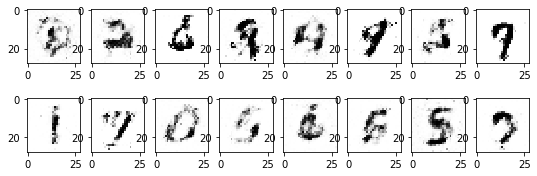

Epoch [17/20], d_loss: 1.2734, g_loss: 1.1458, 


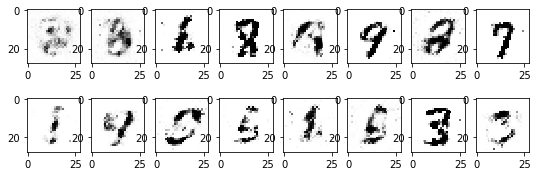

Epoch [18/20], d_loss: 1.2777, g_loss: 1.1453, 


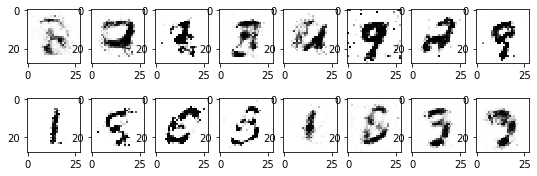

Epoch [19/20], d_loss: 1.1558, g_loss: 1.2207, 


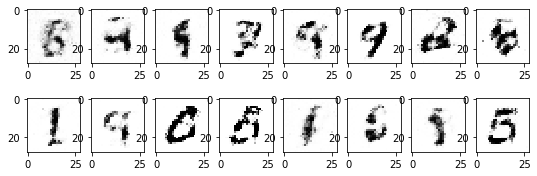

Epoch [20/20], d_loss: 1.3474, g_loss: 1.0634, 


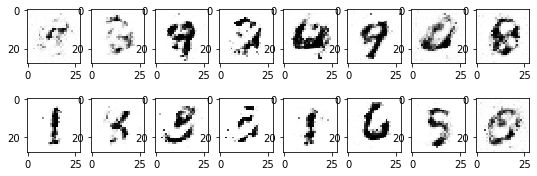

In [ ]:
losses = train(G, D, lr=0.002, batch_size=64, num_epochs=20)

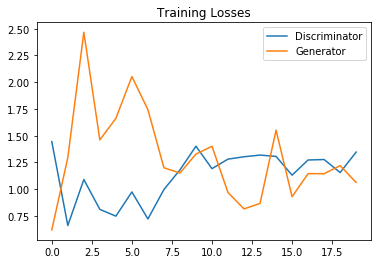

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

GANs are notoriously difficult to train. One difficulty is that a training curve is no longer
as helpful as it was for a supervised learning problem! The generator and discriminator losses
tend to bounce up and down, since both the generator and discriminator are changing over time.
Tuning hyperparameters is also much more difficult, because we don't have the training curve
to guide us. Newer GAN models like Wasserstein GAN tries to alleviate some of these issues, but
are beyond the scope of this course.

To compound the difficulty of hyperparameter tuning GANs also take a long time to train.
It is tempting to stop training early, but the effects of hyperparameters may not be noticable
until later on in training.

You might have noticed in the images generated by our simple GAN that the model seems to only
output a small number of digit types. This phenomenon is called **mode collapse**. A
generator can optimize `P(D correctly identifies image generated by G)` by learning
to generate one type of input (e.g. one digit) really well, and not learning how to
generate any other digits at all!

One approach to prevent mode collapse is to use newer variations of GANs, such as a conditional GAN. A conditional GAN provides additional information to both the discriminator and generator models. In the MNIST example the condition could be the label of the desired digit, and hence it can be used by discriminator as a feature for assessing the goodness of the generated image. Similarly, the generator can use it as a feature for guiding which digit it should try to generate.


##Conditional GAN
The simple GAN we implemented above suffers from a serious problem. It is generating images unconditionally i.e we have no control over the output our model is generating. To overcome this limitation, conditional GANs were invented. The architecture of C-GANs is same as normal GANs but this time the model takes in some metadata as input along with the random noise and conditions the output on that.

A few modifications need to be done to achieve the above objective:
1. The generator model will take random noise of dimension 100 and the digit value as input. We will use an embedding layer of size (10,10) which will have a 10-dimensional encoding for all the 10 digits.

2. We will concatenate the 10-dimensional embedding and the noise to get a 110-dimensional (instead of 100 as in normal Generator model) input that will be fed to the first hidden layer. The rest of the network will perform the same way.

3. Both the above changes will be required for the Discriminator model also.

4. In the training loop:
- Pass the labels along with random noise to the Generator
- Pass the labels along with the data to the Discriminator.
Let’s see how these modifications can be incorporated in the code

## Example Conditional GAN

This kernel is a PyTorch implementation of Conditional GAN, which is a GAN that allows you to choose the label of the generated image. The generator and the discriminator are going to be simple feedforward networks, so I guess the images won't be as good as in this nice kernel by Sergio Gámez. I used this implementation by eriklindernoren as inspiration.

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torchvision import datasets

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


Let's start by defining a Dataset class:

- Data Loading and Processing Tutorial on PyTorch's documentation
- torchvision has a built-in class for Fashion MNIST

In [ ]:
#load from google drive
from google.colab import drive
drive.mount('/content/gdrive')

# location on Google Drive
master_path = '/content/gdrive/My Drive/1_0 Teaching Related/MIE1517 - Deep Learning/Project 3 - GAN/cGAN_MNIST/'
#master_path = '/content/gdrive/My Drive/'


Mounted at /content/gdrive


In [ ]:
# transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# get the training datasets
dataset = datasets.MNIST('data', train=True, download=True, transform=transform)

# prepare data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Now let's define the generator and the discriminator, which are simple MLPs. I'm going to use an embedding layer for the label:

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    # return g_loss.data[0]
    return g_loss.item()

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())

    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    # return d_loss.data[0]
    return d_loss.item()

Starting epoch 0...
g_loss: 1.9624899625778198, d_loss: 0.3994344174861908


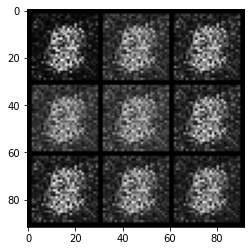

Starting epoch 1...
g_loss: 4.157299995422363, d_loss: 0.2795863747596741


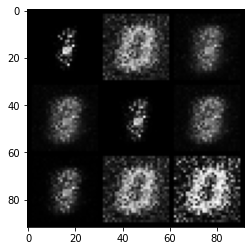

Starting epoch 2...
g_loss: 3.105286121368408, d_loss: 0.3055833876132965


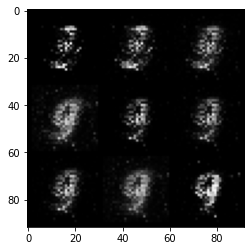

Starting epoch 3...
g_loss: 4.478672027587891, d_loss: 0.25527921319007874


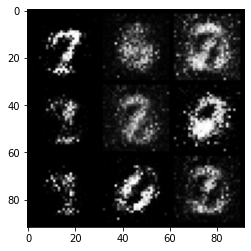

Starting epoch 4...
g_loss: 4.429872512817383, d_loss: 0.15347614884376526


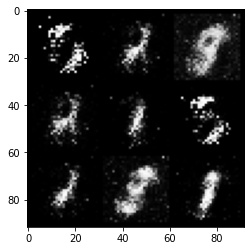

Starting epoch 5...
g_loss: 4.904740333557129, d_loss: 0.24562638998031616


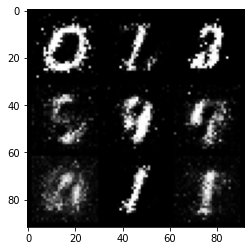

Starting epoch 6...
g_loss: 2.93505859375, d_loss: 0.7338541150093079


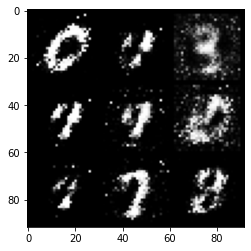

Starting epoch 7...
g_loss: 3.528869152069092, d_loss: 0.43815314769744873


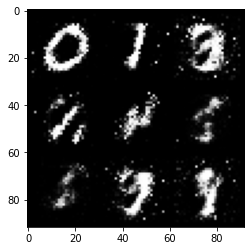

Starting epoch 8...
g_loss: 2.4011306762695312, d_loss: 0.48294597864151


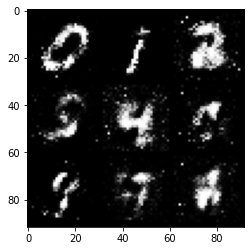

Starting epoch 9...
g_loss: 1.7048304080963135, d_loss: 0.9603716135025024


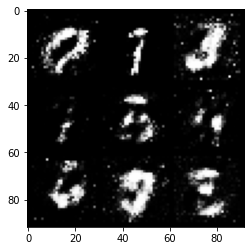

Starting epoch 10...
g_loss: 2.510773181915283, d_loss: 0.5863289833068848


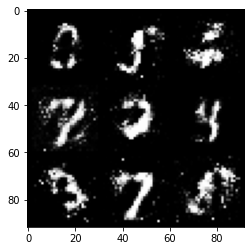

Starting epoch 11...
g_loss: 2.099123477935791, d_loss: 0.5581347942352295


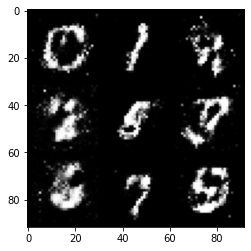

Starting epoch 12...
g_loss: 1.762595534324646, d_loss: 0.676738977432251


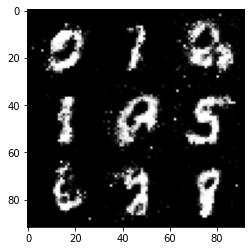

Starting epoch 13...
g_loss: 2.3323094844818115, d_loss: 0.46696799993515015


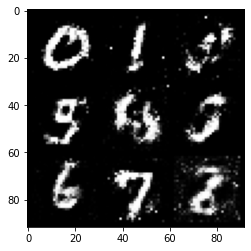

Starting epoch 14...
g_loss: 2.222383737564087, d_loss: 0.4837228059768677


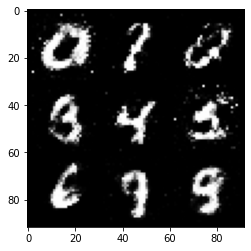

Starting epoch 15...
g_loss: 2.446831703186035, d_loss: 0.666995644569397


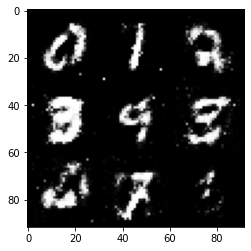

Starting epoch 16...
g_loss: 2.036731004714966, d_loss: 0.665131151676178


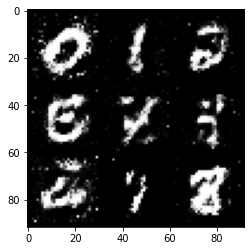

Starting epoch 17...
g_loss: 2.342289447784424, d_loss: 0.8107046484947205


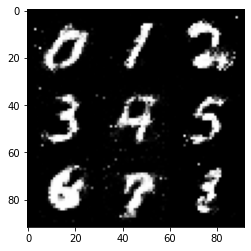

Starting epoch 18...
g_loss: 1.6274330615997314, d_loss: 0.656731128692627


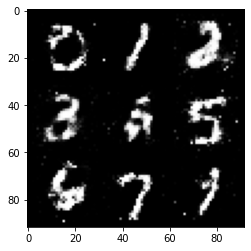

Starting epoch 19...
g_loss: 1.6224493980407715, d_loss: 0.9281851053237915


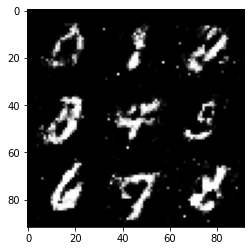

Starting epoch 20...
g_loss: 2.065535068511963, d_loss: 0.5621649622917175


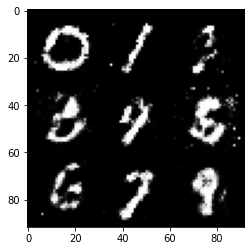

Starting epoch 21...
g_loss: 1.6823134422302246, d_loss: 0.7253884077072144


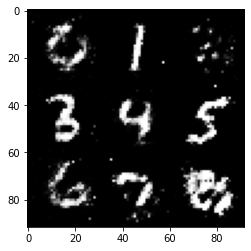

Starting epoch 22...
g_loss: 1.3436915874481201, d_loss: 1.1654353141784668


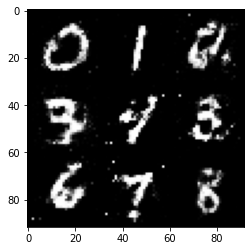

Starting epoch 23...
g_loss: 1.3913744688034058, d_loss: 0.9069226980209351


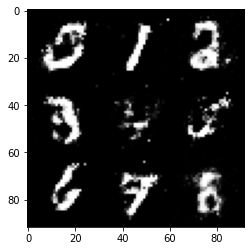

Starting epoch 24...
g_loss: 1.831618070602417, d_loss: 0.8476914763450623


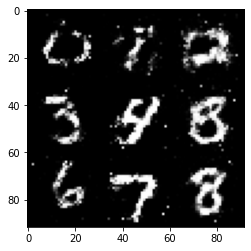

Starting epoch 25...
g_loss: 1.2320950031280518, d_loss: 1.0387012958526611


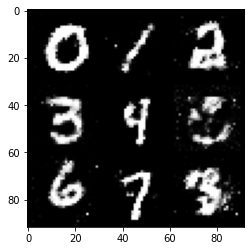

Starting epoch 26...
g_loss: 1.1269155740737915, d_loss: 1.1706733703613281


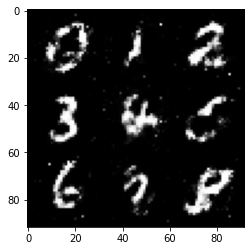

Starting epoch 27...
g_loss: 1.1967979669570923, d_loss: 1.1213949918746948


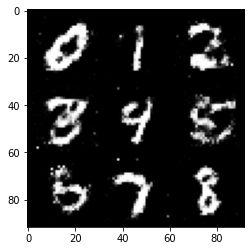

Starting epoch 28...
g_loss: 1.1549599170684814, d_loss: 0.9001171588897705


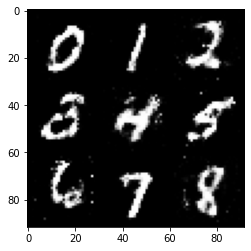

Starting epoch 29...
g_loss: 1.1664116382598877, d_loss: 0.7147831320762634


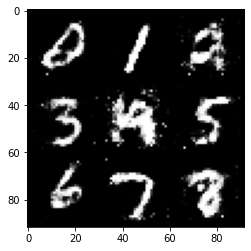

In [ ]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

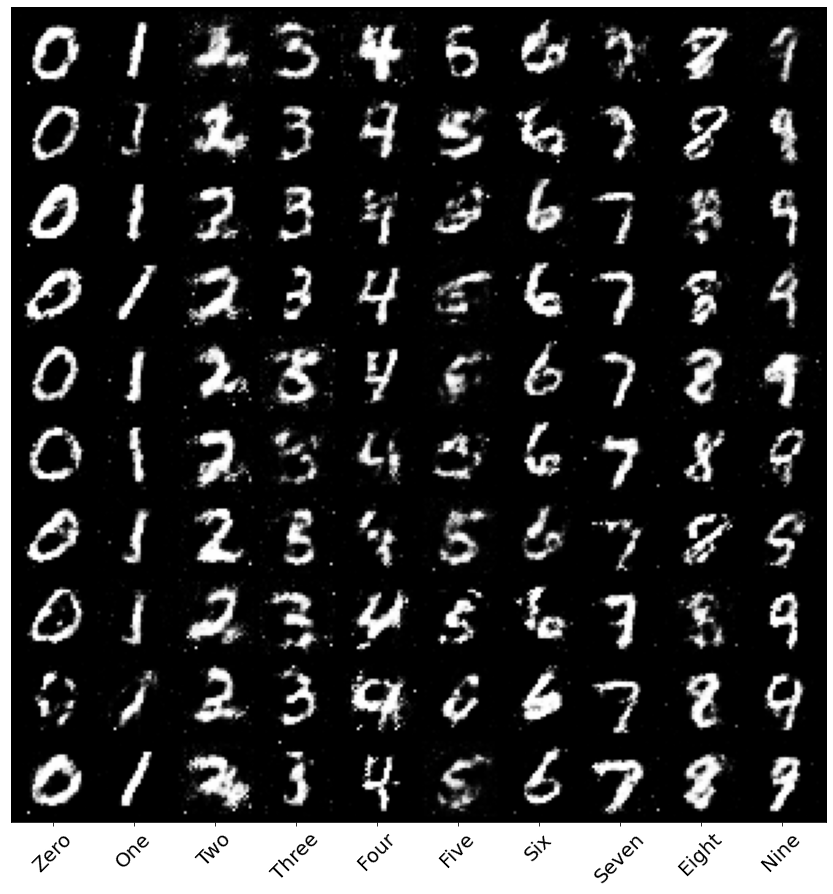

In [ ]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine'], rotation=45, fontsize=20)